In [1]:
import os
import sys
import matplotlib.pyplot as plt

os.chdir('..')

import numpy as np
import torch
import pandas as pd
import random

from models.TrainPlanningOperator3D import PlanningOperator3D

from planners import generaterandompos
from planners import AStarPlanner, FMMPlanner, PlanningOperatorPlanner, testplanneronmaps, plot_2d_map_and_two_paths



Load Gibson Environment

In [2]:
Ntotal = 50

ntest = 5
ntrain = 45

sub = 1
Sx = 84
Sy = 84
Sz = 84

maps = np.load('dataset/occupancy_maps.npy')
maps = maps[:Ntotal][-ntest:, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]
# maps = maps[:Ntotal][:ntrain, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]
# maps = maps[0:8,:,:,:]
# maps = np.repeat(maps, repeats=5, axis=0)



Load Model

In [3]:


# Model
modes = 12
width = 32
nlayers = 1

model = PlanningOperator3D(modes, modes, modes, width, nlayers)
model.load_state_dict(torch.load("/mountvol/igibchunk-dataset-84-10g/planningoperator_env84_m12_w32_l1_b10_lr3e-3_10g_23sep/n450_lr3.000000e-03_gamma6.000000e-01_wd3.000000e-06_seed5/model3d.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/tmp/ipykernel_11919/19159190.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/mountvol/igibchunk-dataset-84-10g/planningoperator_env84

PlanningOperator3D(
  (fc0): Linear(in_features=3, out_features=32, bias=True)
  (conv0): SpectralConv3d()
  (w0): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (fc1): DeepNormMetric(
    (Us): ModuleList(
      (0-1): 2 x Linear(in_features=32, out_features=128, bias=False)
    )
    (Ws): ModuleList(
      (0): ConstrainedLinear(in_features=128, out_features=128, bias=False)
    )
    (activation): MaxReLUPairwiseActivation(
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (output_activation): ConcaveActivation()
    (reduce_metric): ReduceMetric()
  )
)

Start [51 78 31]
Goal [47 68 10]

AStar
Success: True 
PathCost: 26.41348460451408 
PlanningTime: 0.11796998977661133

FMM
Success: True 
PathCost: 26.413484604514082 
PlanningTime: 0.29616308212280273

Planning Operator
Success: True 
PathCost: 30.90216576710466 
Total Time 0.5523102283477783


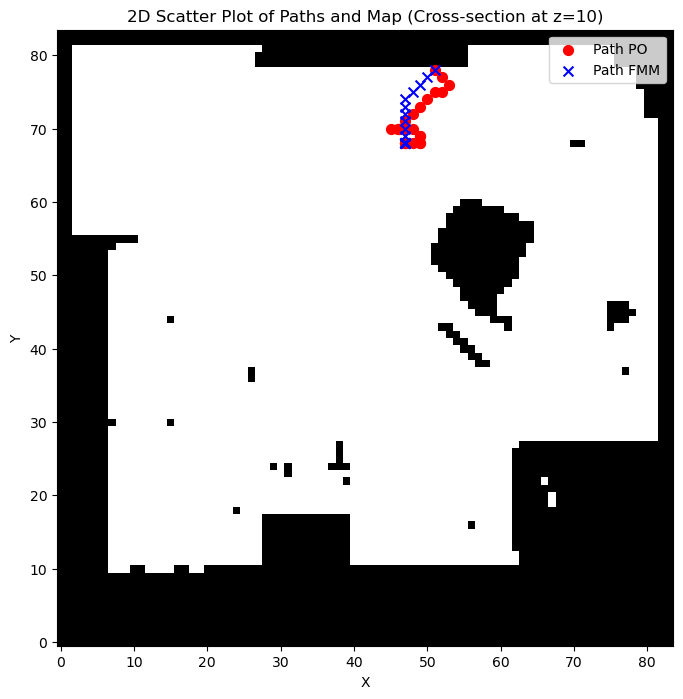

In [4]:
startpositions = generaterandompos(maps)
goalpositions = generaterandompos(maps)
index =  np.random.randint(0, maps.shape[0])  
mapx = maps[index,:,:,:]
startx = startpositions[index,:]
print("Start",startx)
goalx = goalpositions[index,:]
# goalx[2] = startx[2]
print("Goal",goalx)


success,pathcost,planningtime, path = AStarPlanner(startx, goalx, mapx)

print("\nAStar\nSuccess:", success,
      "\nPathCost:", pathcost,
      "\nPlanningTime:",planningtime)


success,pathcost,planningtime, path_1 = FMMPlanner(startx, goalx, mapx)
print("\nFMM\nSuccess:", success,
      "\nPathCost:", pathcost,
      "\nPlanningTime:",planningtime)


success,pathcost,tot_time, path_2 = PlanningOperatorPlanner(startx, goalx, mapx, model)
print("\nPlanning Operator\nSuccess:", success,
      "\nPathCost:", pathcost,
      "\nTotal Time", tot_time)


plot_2d_map_and_two_paths(path_2,path_1,mapx,z_index=goalx[2])


Generate Random Positions

In [5]:
maps = np.repeat(maps, repeats=5, axis=0)
startpositions = generaterandompos(maps)
# print(startpositions)
goalpositions = generaterandompos(maps)
# goalpositions[0][2] = startpositions[0][2]
# print(goalpositions)

In [6]:
testplanneronmaps(startpositions,goalpositions,maps,AStarPlanner,printvalues=True)

25it [00:17,  1.47it/s]

Average Path Cost: 44.67214546050276 
Average Planning Time: 0.6804997444152832 
Average Success Rate: 1.0


(44.67214546050276, 0.6804997444152832, 1.0)

In [7]:
testplanneronmaps(startpositions,goalpositions,maps,FMMPlanner,printvalues=True)

25it [00:03,  6.77it/s]

Average Path Cost: 45.055627517444044 
Average Planning Time: 0.14644645690917968 
Average Success Rate: 1.0


(45.055627517444044, 0.14644645690917968, 1.0)

In [8]:
testplanneronmaps(startpositions,goalpositions,maps,PlanningOperatorPlanner,printvalues=True, model=model)

25it [00:08,  3.12it/s]

Average Path Cost: 38.29481977752566 
Average Planning Time: 0.26322022606344786 
Average Success Rate: 0.68


(38.29481977752566, 0.26322022606344786, 0.68)